#### Go to https://pytorch.org/ and follow the instructions to install PyTorch.

## Imports

In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
from tqdm import tqdm
%matplotlib inline

## Create dataset

In [2]:
#Simulate training and test data
n_train = 200
Xtrain, Ytrain = np.meshgrid(np.linspace(-3,3,n_train),np.linspace(-3,3,n_train))
Ztrain = np.real(Xtrain**2 + Ytrain**2 <=1)

Xtrain = torch.from_numpy(Xtrain.ravel(order='F'))
Ytrain = torch.from_numpy(Ytrain.ravel(order='F'))
Ztrain = torch.from_numpy(Ztrain.ravel(order='F').astype(float))

n_test = 30
Xtest, Ytest = np.meshgrid(np.linspace(-3,3,n_test),np.linspace(-3,3,n_test))
Ztest = np.real(Xtest**2 + Ytest**2 <=1)

Xtest = torch.from_numpy(Xtest.ravel(order='F'))
Ytest = torch.from_numpy(Ytest.ravel(order='F'))
Ztest = torch.from_numpy(Ztest.ravel(order='F').astype(float))

#Create datasets and dataloaders
inputs_train = torch.cat((Xtrain.unsqueeze(1), Ytrain.unsqueeze(1)), dim=1)
inputs_test = torch.cat((Xtest.unsqueeze(1), Ytest.unsqueeze(1)), dim=1)

dataset_train = Data.TensorDataset(inputs_train.type(torch.FloatTensor), Ztrain.type(torch.FloatTensor))
dataset_test = Data.TensorDataset(inputs_test.type(torch.FloatTensor), Ztest.type(torch.FloatTensor))

BATCH_SIZE=500
dataloader_train = Data.DataLoader(
    dataset=dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True)
dataloader_test = Data.DataLoader(
    dataset=dataset_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

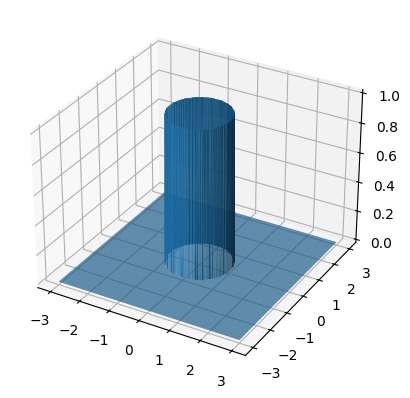

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.plot_trisurf(Xtrain, Ytrain, Ztrain)

## Artificial Neural Network

## 1 Fitting a regression artificial neural network to a cylinder:

### One-layer ANN

> Create a 1 layer network serving as the baseline 

In [16]:
# ann with 1 layer
#Design a 1 hidden layer NN with Pytorch: You need to define the network in the __init__ function and design the forward pass
# See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html for help
class OneLayerNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(OneLayerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        
    def forward(self, x):
        return self.net(x).flatten()

number_of_features = 2
hidden_nodes =  100
learning_rate = 0.001
    
one_layer_net = OneLayerNet(n_feature=number_of_features, n_hidden=hidden_nodes, n_output=1)     # define the network
print(one_layer_net)  # net architecture
optimizer = torch.optim.Adam(one_layer_net.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

OneLayerNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


100%|██████████| 300/300 [02:48<00:00,  1.78it/s]


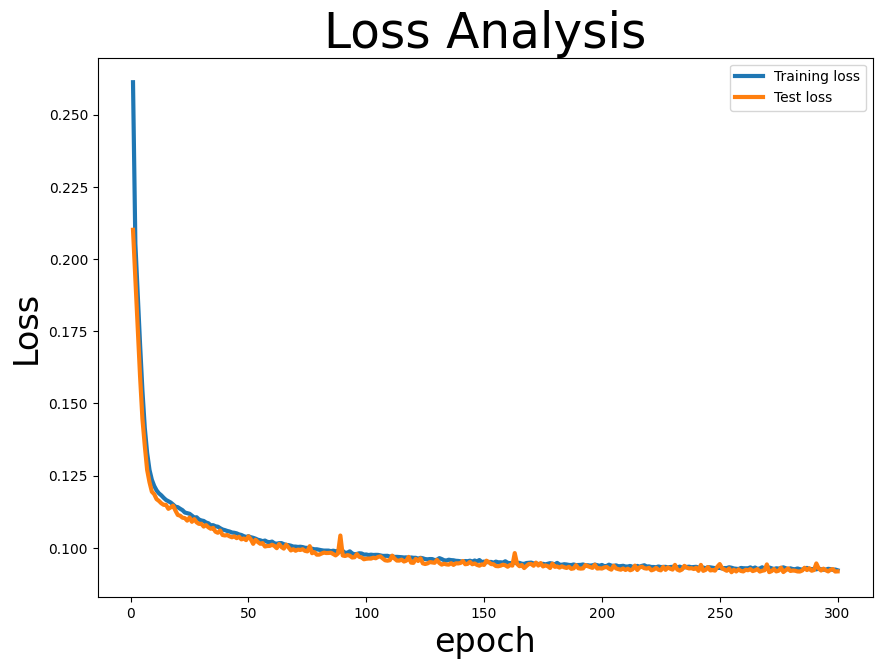

In [17]:
EPOCH = 300
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
test_loss_graph = []
for epoch in tqdm(range(EPOCH)):
    train_loss_tot = 0 # Save for plotting
    one_layer_net.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(dataloader_train): # for each training step
        
        
        predictions = one_layer_net(inputs_)     # input x and predict based on x
    
        loss = torch.sqrt(loss_func(predictions, targets_))   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    one_layer_net.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(dataloader_test): # for each testing batch
                
        predictions = one_layer_net(inputs_)     # input x and predict based on x
    
        loss = torch.sqrt(loss_func(predictions, targets_))  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(dataset_train))
    test_loss_graph.append(test_loss_tot/len(dataset_test))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer


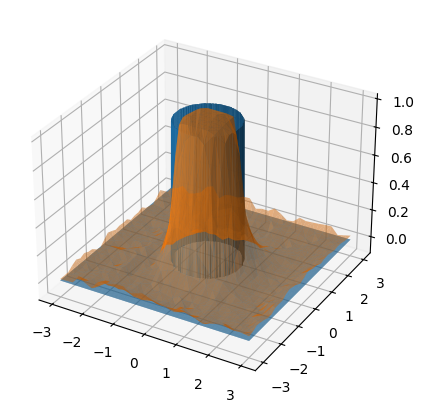

In [18]:
# final prediction
prediction = one_layer_net(inputs_test.type(torch.FloatTensor))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection = '3d')
ax.plot_trisurf(Xtrain, Ytrain, Ztrain)
ax.plot_trisurf(Xtest, Ytest, prediction.detach().numpy(), alpha=0.5)

## Two-layer ANN

> What is the minimum number of nodes in a two layer network that outperformce one layer with 100 nodes?

In [20]:
# ann with 2 layers
#Design a 2 hidden layer NN with Pytorch: You need to define the network in the __init__ function and design the forward pass
# See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html for help
class TwoLayerNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_layer1, n_hidden_layer2, n_output):
        super(TwoLayerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_feature, n_hidden_layer1),
            nn.ReLU(),
            nn.Linear(n_hidden_layer1, n_hidden_layer2),
            nn.ReLU(),
            nn.Linear(n_hidden_layer2, n_output)
        )
        
    def forward(self, x):
        return self.net(x).flatten()

    

number_of_features = 2
hidden_nodes_layer1 = 15 #Modify this
hidden_nodes_layer2 = 15 #Modify this
learning_rate = 0.001
    
two_layer_net = TwoLayerNet(n_feature=number_of_features, n_hidden_layer1=hidden_nodes_layer1, n_hidden_layer2=hidden_nodes_layer2, n_output=1)     # define the network
print(two_layer_net)  # net architecture
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

TwoLayerNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [03:15<00:00,  1.53it/s]


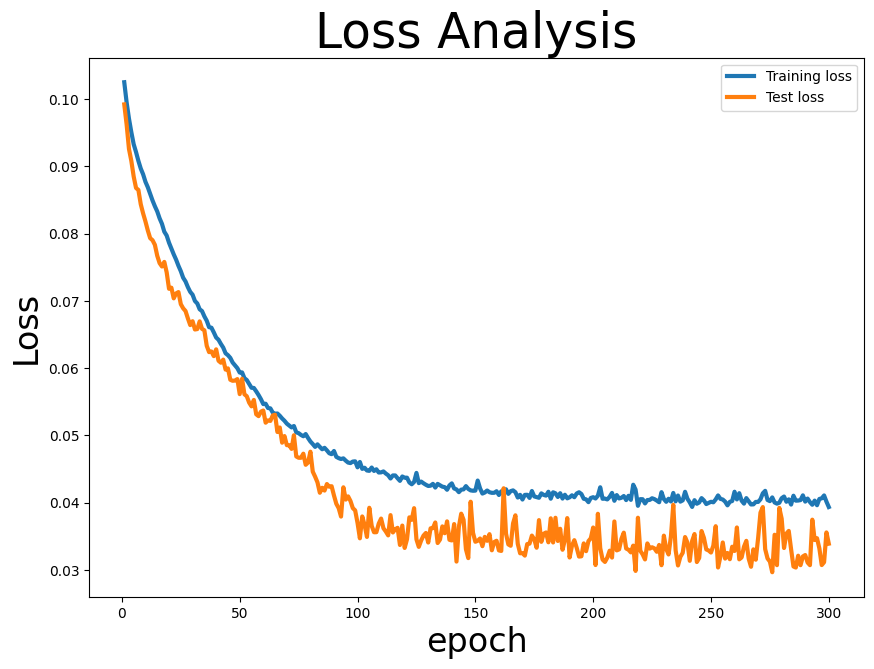

In [22]:
EPOCH = 300
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
test_loss_graph = []
for epoch in tqdm(range(EPOCH)):
    train_loss_tot = 0 # Save for plotting
    two_layer_net.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(dataloader_train): # for each training step
        
        
        predictions = two_layer_net(inputs_)     # input x and predict based on x
    
        loss = torch.sqrt(loss_func(predictions, targets_))   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    two_layer_net.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(dataloader_test): # for each testing batch
                
        predictions = two_layer_net(inputs_)     # input x and predict based on x
    
        loss = torch.sqrt(loss_func(predictions, targets_))  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(dataset_train))
    test_loss_graph.append(test_loss_tot/len(dataset_test))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer


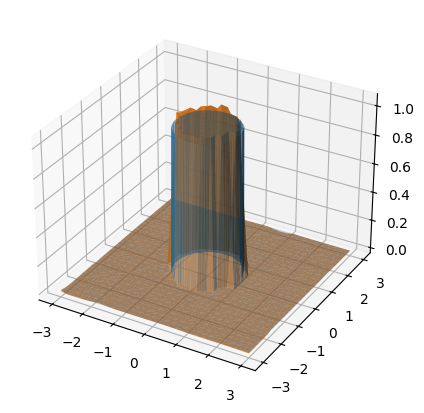

In [28]:
# final prediction
prediction = two_layer_net(inputs_test.type(torch.FloatTensor))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection = '3d')
ax.plot_trisurf(Xtrain, Ytrain, Ztrain, alpha=0.3)
ax.plot_trisurf(Xtest, Ytest, prediction.detach().numpy(), alpha=0.7)

plt.show()